#### **Import Libraries**

In [1]:
from IPython.display import display
from IPython.display import Markdown
import textwrap
import os 
from pathlib import Path
import pandas as pd
import tiktoken
from pathlib import Path
from trics.nlp.utils import to_markdown, create_csv_with_headers
import csv
import time 
import logging
import re 
import numpy as np
import anthropic

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_24pt/Newsreader_24pt-LightItalic.ttf


In [3]:
version = 1
prompt = False 
sample_size = 3000
noise = False

In [4]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

In [5]:
conditions_not_covered = [
    "Short-term illnesses",
    "Temporary exhaustion",
    "Behavioral Traits and Conditions",
    "Having a quick temper without any underlying medical condition",
    "Certain Addictions",
    "Substance abuse disorders",
    "good health"
]

conditions_covered = [
    "Mobility impairments",
    "Visual impairments",
    "Hearing impairments",
    "Chronic illnesses",
    "Respiratory disorders",
    "Cardiovascular conditions",
    "Intellectual disabilities",
    "Learning disabilities",
    "Autism spectrum disorders",
    "Psychiatric disorders",
    "Traumatic brain injuries",
    "Alzheimer's disease and other dementias"
]

disabilities = conditions_covered + conditions_not_covered

# Create a list of (0,1)s
severity_indicator = [1 if disability in conditions_covered else 0 for disability in disabilities]

def fstage(var1, var2, var3, var4, var5, var6, var7, var8, var9):
    return 0.35*severity_indicator[var5] + 0.35*var9

In [6]:
import re 

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.\n\n Description:'
string1 = "\n\n Note: The tenant has access to a free lawyer."
string0 = "\n\n Note: The tenant does not have access to a free lawyer."

context = " Access to a lawyer does not mean the tenant will be represented in court by a lawyer." \
        " If the tenant is given access to a lawyer, they must apply for representation." \
        " Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications." \
        " Providers can differ over what they consider to be a dissability."\
        " If a tenant's application is selected, they must follow-up with the provider to arange for legal representation." \
        " Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation."

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4'], 
                                                 row['Var5'],
                                                 row['Var6'],
                                                 row['Var7'],
                                                 row['Var8'],
                                                 row['Var9']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1, df['Description'] + string1, df['Description'] + string0)

# Text + Instrument == 1
df['Treated_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string1, axis=1)

# Text + Instrument == 0
df['Control_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string0, axis=1)

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

def received(x):
    return  'The tenant received legal representation' if x == 1 else 'The tenant did not receive legal representation.'

df['Treatment_word'] = df.Treatment.apply(received)
# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + 0.1*np.random.normal(size=sample_size)

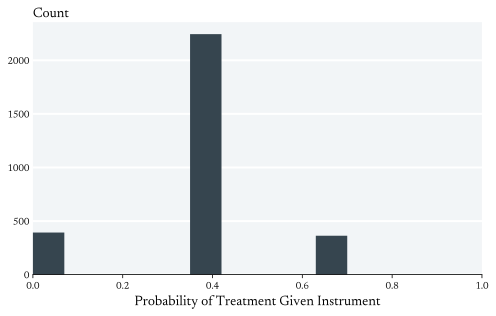

In [7]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

#### **Setup Client**

In [68]:
from openai import OpenAI
os.environ["OPENAI_API_KEY"] =  
client = OpenAI()

def get_completion(prompt, model='gpt-4o'):
    messages = [{"role": "system", "content": "You are smart and precise AI"}, {"role": "user", "content": prompt}]
    response =  client.chat.completions.create(model=model, messages=messages,temperature=0.)
    return response.choices[0].message.content 

def initiate_prompt(examples, context, test_example):
    prompt = f"""
    Based only the following examples and the context provided, predict the precise probability (as a percentage between 0 and 100) that the tenant described in the test example receives legal representation. 

    Context:
    ```{context}```

    Examples:
    ```{examples}```

    Test Example: 
    ```{test_example}```

    Probability:
    """
    return prompt

In [69]:
df.shape

(3000, 18)

In [74]:
k = 250 
examples = df.loc[:k, 'FullDescription'] + ' ' + df.loc[:k, 'Treatment_word']
test_example = df.loc[k+1, 'FullDescription']
prompt = initiate_prompt(examples.values, context, test_example)

In [75]:
df.shape

(3000, 18)

In [76]:
to_markdown(test_example)

> The tenant is a mid-30s individual facing financial difficulties, having fallen behind on rent by $700. Despite their mobility impairments, they have called a small apartment complex home for the past 53 months. Within their modest living space, they find solace in the tranquility of a fish tank. Although their family does not contribute to the rent, the tenant finds joy in attending cooking classes, a hobby that brings them a sense of fulfillment amidst the challenges they navigate.
> 
>  Note: The tenant does not have access to a free lawyer.

In [77]:
to_markdown(get_completion(prompt))

> Based on the provided context and examples, the probability that the tenant in the test example receives legal representation can be determined by analyzing the key factors that influence representation:
> 
> 1. **Access to a Free Lawyer**: The tenant does not have access to a free lawyer, which significantly reduces the probability of receiving legal representation.
> 2. **Disabilities**: The tenant has mobility impairments, which is a factor that can increase the likelihood of being prioritized for legal representation.
> 3. **Family Contribution**: The tenant's family does not contribute to the rent, which does not directly affect the probability but indicates financial strain.
> 4. **Length of Tenancy**: The tenant has been living in the apartment complex for 53 months, which shows stability in their living situation.
> 5. **Financial Difficulty**: The tenant is behind on rent by $700, indicating financial difficulties.
> 
> From the examples, tenants who do not have access to a free lawyer generally do not receive legal representation, even if they have disabilities. The presence of a disability alone does not guarantee representation without access to a free lawyer.
> 
> Given these factors, the probability that the tenant in the test example receives legal representation is very low. Based on the patterns observed in the examples, I would estimate the probability to be around 5%.
> 
> **Probability: 5%**

#### **Helper Function**

In [4]:
def extract_rent(text):
    # Regular expression pattern to find monetary amounts
    match = re.search(r'\$\d{1,3}(?:,\d{3})*(?:\.\d{2})?', text)
    if match:
        # Remove dollar sign and commas, convert to float
        rent = match.group(0).replace('$', '').replace(',', '')
        return float(rent)
    else:
        return np.nan

#### **Set Up Path**

In [5]:
input_version = 1 
output_version = 1
github_folder = str(Path(os.getcwd()).parent.parent.parent.parent.absolute())
figure_folder = github_folder + "/rtc_paper/figures/"
landlord_complaints_csv = github_folder + f'/evictions/data/judicial/complaints_{input_version}.csv'
cases = github_folder + "/evictions/data/judicial/clean_cases2.csv"
housing_voucher_csv = github_folder + f'/evictions/data/judicial/housing_voucher_{output_version}.csv'

#### **Define File**

In [6]:
if os.path.exists(housing_voucher_csv):
    print(f'Monthly Rent for version {output_version} exists')
else:
    create_csv_with_headers(housing_voucher_csv, ['DocketNo', 'Voucher'])

File not found. Creating new file with headers: ['DocketNo', 'Voucher']


#### **Read In Data**

In [7]:
df_complaints = pd.read_csv(landlord_complaints_csv)
df_cases = pd.read_csv(cases)
df_cases['FileDate'] = pd.to_datetime(df_cases['FileDate'])
logger.info(f'Number of cases: {len(df_cases)}')
df_cases = df_cases[(df_cases['FileDate'] >= '2022-01-01') & (df_cases['FileDate'] < '2022-11-01')]
logger.info(f'Number of cases after filtering: {len(df_cases)}')
df = pd.merge(df_complaints, df_cases, on='DocketNo', how='inner')
logger.info(f'Number of complaints after merging: {len(df)}')
df_housing_voucher = pd.read_csv(housing_voucher_csv)
df = df[~df['DocketNo'].isin(df_housing_voucher['DocketNo'])]
df = df[['DocketNo', 'Complaint']]
logger.info(f'Number of complaints to get housing voucher from: {len(df)}')

2024-05-15 17:32:54,393 - INFO - Number of cases: 104908
2024-05-15 17:32:54,404 - INFO - Number of cases after filtering: 18573
2024-05-15 17:32:54,419 - INFO - Number of complaints after merging: 15016
2024-05-15 17:32:54,427 - INFO - Number of complaints to get housing voucher from: 15016


#### **Extract Rent**

In [8]:
for i, (j, k) in df.iterrows():
    text = anthropic_completion(initiate_prompt(k), model='claude-3-haiku-20240307')
    # clean_text = extract_rent(text)
    with open(housing_voucher_csv, 'a') as f:
        writer = csv.writer(f)
        writer.writerow([j, text])
        print(f'\tCompleted Scraping {i}')
        time.sleep(0.1)
    if i > 20:
        break 

	Completed Scraping 0
	Completed Scraping 1
	Completed Scraping 2
	Completed Scraping 3
	Completed Scraping 4
	Completed Scraping 5
	Completed Scraping 6
	Completed Scraping 7
	Completed Scraping 8
	Completed Scraping 9
	Completed Scraping 10
	Completed Scraping 11
	Completed Scraping 12
	Completed Scraping 13
	Completed Scraping 14
	Completed Scraping 15
	Completed Scraping 16
	Completed Scraping 17
	Completed Scraping 18
	Completed Scraping 19
	Completed Scraping 20
	Completed Scraping 21


In [9]:
df_temp = pd.read_csv(housing_voucher_csv)
df_temp['Voucher'].values

array(['Based on the information provided in the text, the response is Inconclusive. The text does not mention anything about the tenant having a Section 8 housing voucher. The text only states that the defendant "once had the right or privilege to occupy the premises, but such right or privilege has been terminated." Without any explicit mention of a Section 8 housing voucher, the information provided is not sufficient to determine whether the tenant has one or not.',
       'Based on the information provided in the text, there is no mention of the tenant having a Section 8 housing voucher. The text appears to be a summary process (eviction) complaint for termination of a lease due to lapse of time. It does not indicate whether the tenant has a Section 8 housing voucher. Therefore, the answer is Inconclusive.',
       'Based on the information provided in the text, there is no indication that the tenant has a Section 8 housing voucher. The text describes a standard residential lease a